# Seatbelt classification with Tensorflow

### Import necessary libraries

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os

### Prepare data to train model

In [3]:
data = []
label = []
types = ['train', 'test']
classes = ['Taqilgan', 'Taqilmagan', 'Aniqlanmadi']
for i in range(len(types)):
    for j in range(len(classes)):
        images = glob('Data/'+types[i]+'/'+classes[j]+'/*')
        for img in images:
            rasm = cv2.imread(img)
            data.append(rasm)
            label.append(j)
        
data = np.array(data)
label = np.array(label)

In [5]:
num_classes = 3
label = keras.utils.to_categorical(label, num_classes)

trainX, testx, trainY, testy = train_test_split(data, label, test_size=0.10, random_state=707)
trainx, valx, trainy, valy = train_test_split(trainX, trainY, test_size=0.18, random_state=707)
print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)
print(testx.shape, testy.shape)

(1796, 320, 320, 3) (1796, 3)
(395, 320, 320, 3) (395, 3)
(244, 320, 320, 3) (244, 3)


### Create model

In [6]:
epochs = 200

model = keras.Sequential([
    keras.layers.Rescaling(1/255.0, input_shape=(320,320,3)),
    
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    
    keras.layers.Conv2D(16, (3,3),padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(32, (3,3),padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3,3),padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3,3),padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(256, (3,3),padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(512, (3,3),padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 320, 320, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 320, 320, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 320, 320, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 320, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 320, 320, 16)     64        
 ormalization)                                          

### Training model

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [11]:
with tf.device('/GPU:0'):
    H = model.fit(trainx, trainy, validation_data=(valx, valy), epochs=epochs)

Epoch 1/200
57/57 [==============================] - 37s 659ms/step - loss: 1.1978 - accuracy: 0.4972 - val_loss: 3.7336 - val_accuracy: 0.3747
Epoch 2/200
57/57 [==============================] - 32s 564ms/step - loss: 1.0652 - accuracy: 0.5273 - val_loss: 1.9178 - val_accuracy: 0.3747
Epoch 3/200
57/57 [==============================] - 32s 564ms/step - loss: 1.0312 - accuracy: 0.5290 - val_loss: 1.8567 - val_accuracy: 0.3747
Epoch 4/200
57/57 [==============================] - 32s 566ms/step - loss: 0.9866 - accuracy: 0.5362 - val_loss: 1.5679 - val_accuracy: 0.3747
Epoch 5/200
57/57 [==============================] - 32s 565ms/step - loss: 0.9225 - accuracy: 0.5646 - val_loss: 1.7854 - val_accuracy: 0.3747
Epoch 6/200
57/57 [==============================] - 32s 565ms/step - loss: 0.9115 - accuracy: 0.5668 - val_loss: 1.4742 - val_accuracy: 0.3823
Epoch 7/200
57/57 [==============================] - 33s 572ms/step - loss: 0.9168 - accuracy: 0.5568 - val_loss: 2.2140 - val_accuracy:

8/8 [==============================] - 1s 73ms/step - loss: 1.2621 - accuracy: 0.7049


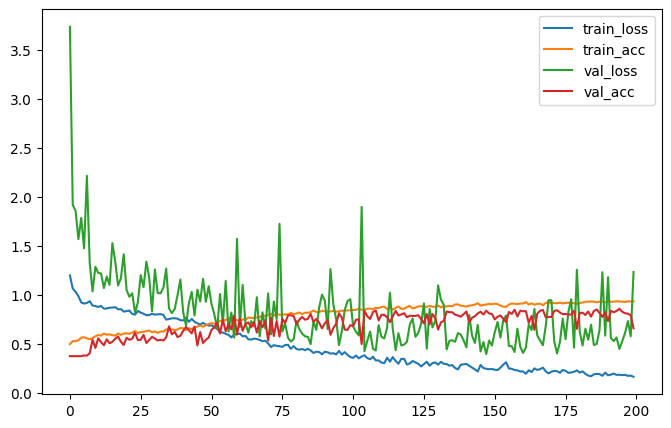

In [12]:
model.evaluate(testx,testy)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(epochs),H.history['loss'], label="train_loss")
plt.plot(np.arange(epochs),H.history['accuracy'], label="train_acc")

plt.plot(np.arange(epochs),H.history['val_loss'], label="val_loss")
plt.plot(np.arange(epochs),H.history['val_accuracy'], label="val_acc")
plt.legend(loc="upper right")

model.save('models/seatbelt.model', save_format='h5')

### Model accuracy check

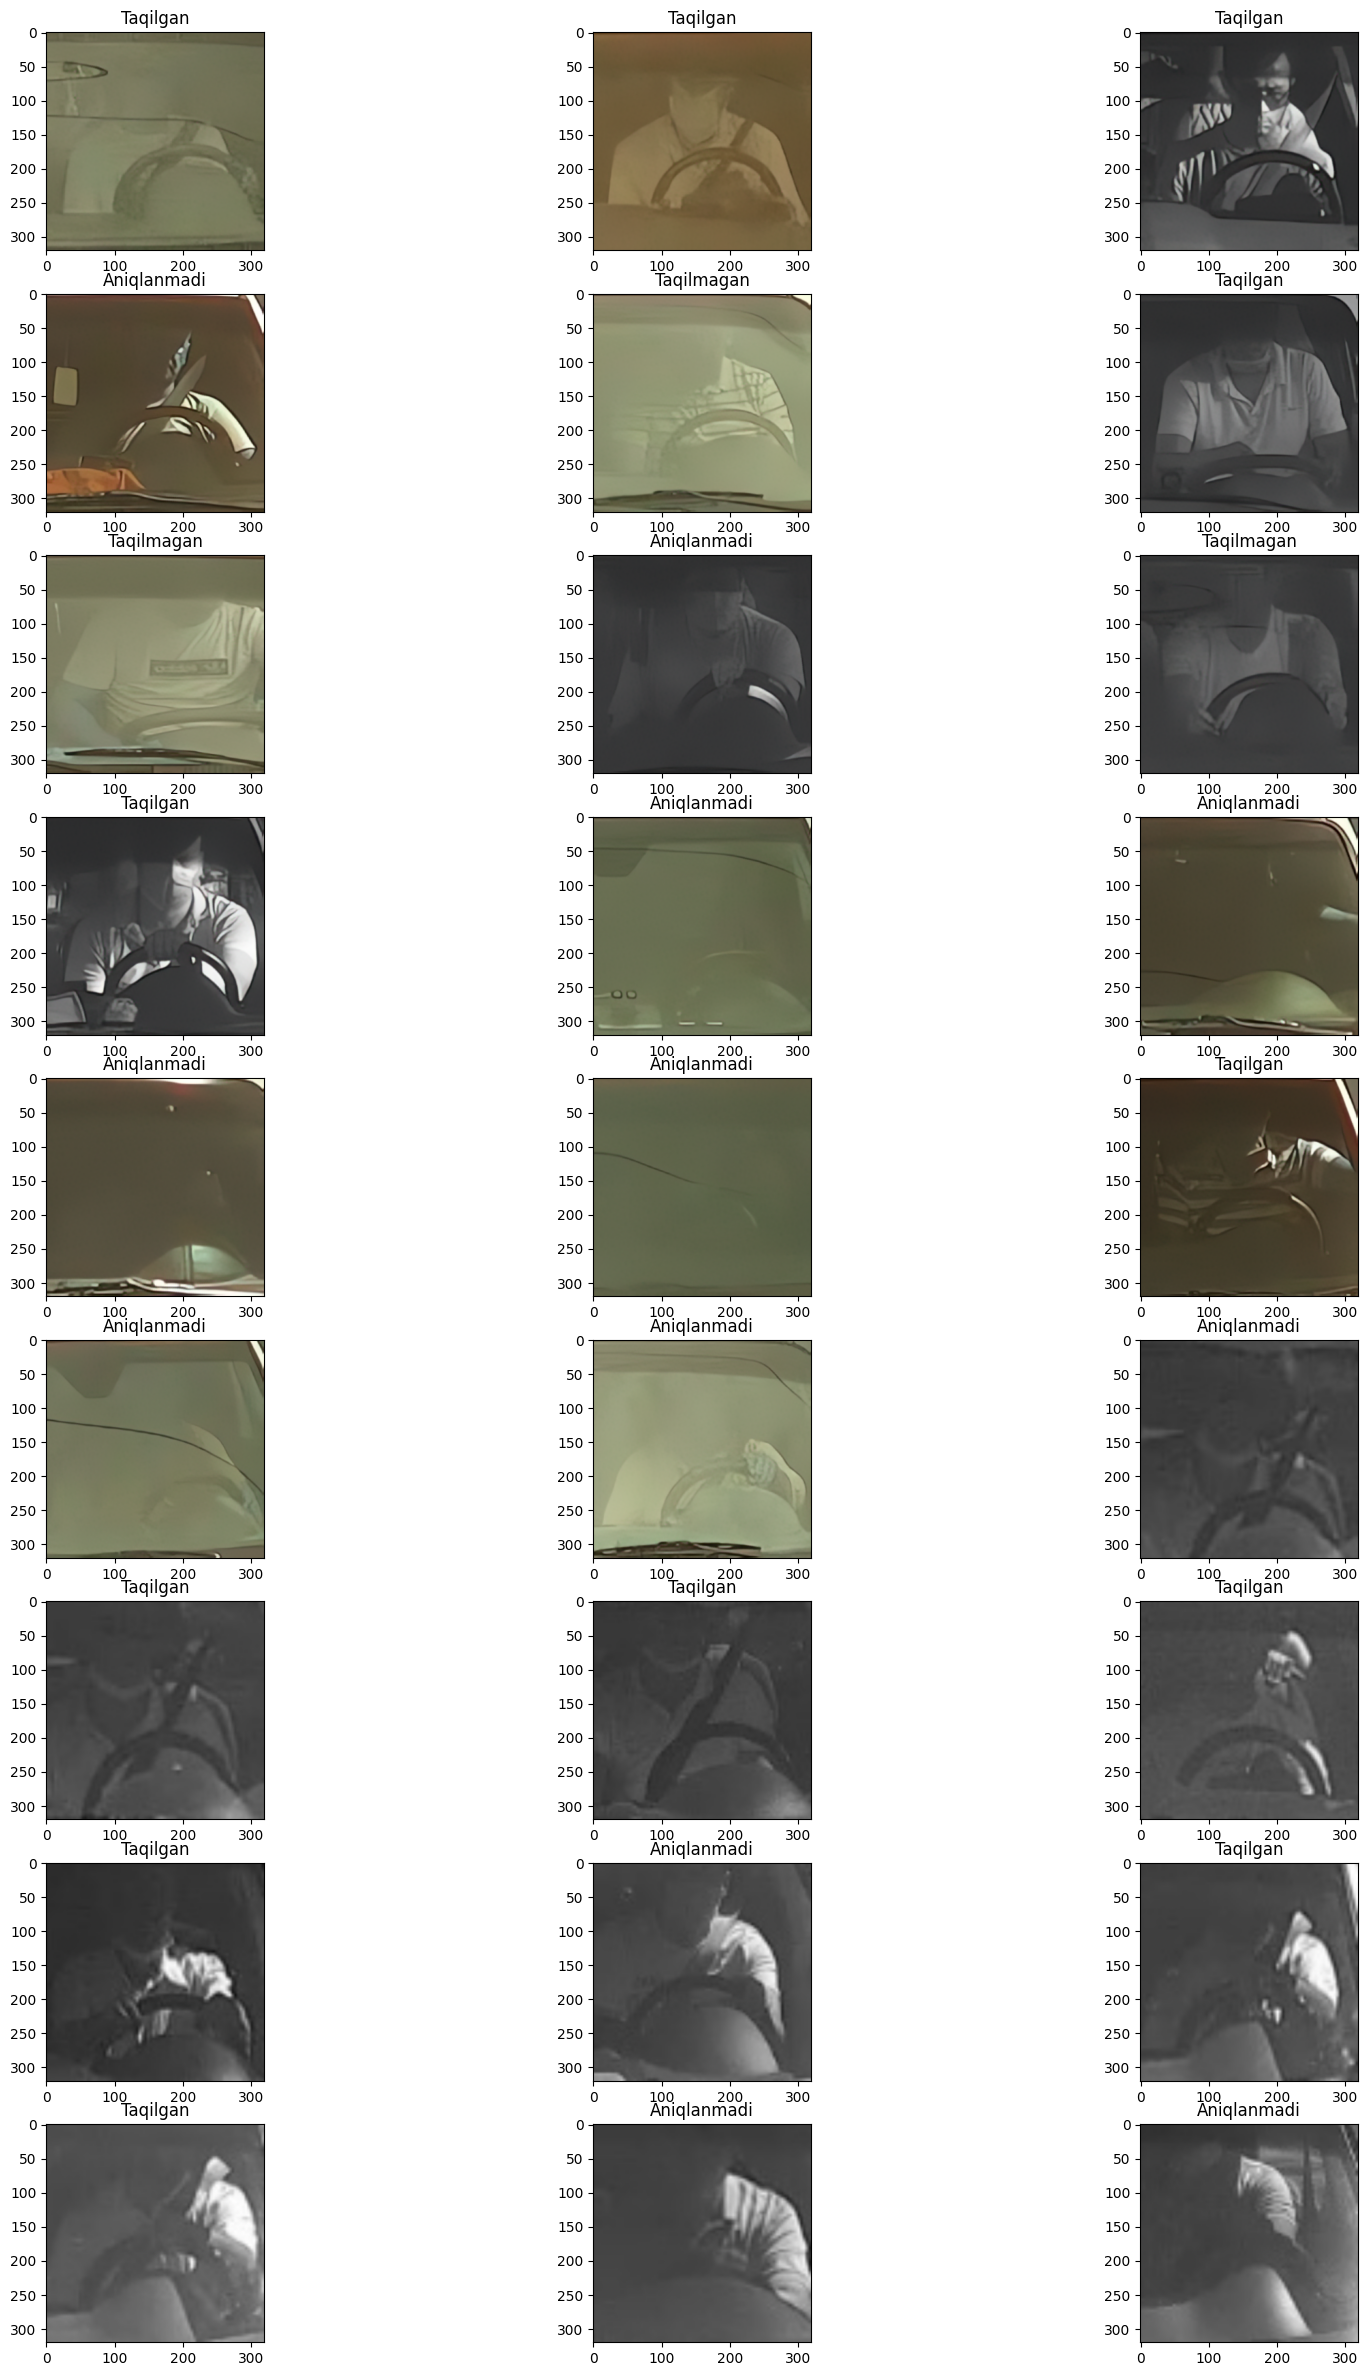

In [15]:
# test for model
import cv2
import numpy as np
from glob import glob
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# PREPARING IMAGES AND PREDICTING
model = load_model('models/seatbelt.model')
types = ['Taqilgan', 'Taqilmagan', 'Aniqlanmadi']

rasmlar = glob('Test/*')
plt.figure(figsize=(20,30))
for i in range(len(rasmlar)):
    rasm = cv2.imread(rasmlar[i])
    rasm = cv2.resize(rasm, (320,320))
    plt.subplot(9, 3, i+1)
    plt.imshow(rasm)
    ind = np.argmax(model(np.expand_dims(rasm,axis=0)))
    plt.title(types[ind])


# Image Super Resolution

c:\Users\abbss\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


0.0 % accuracy


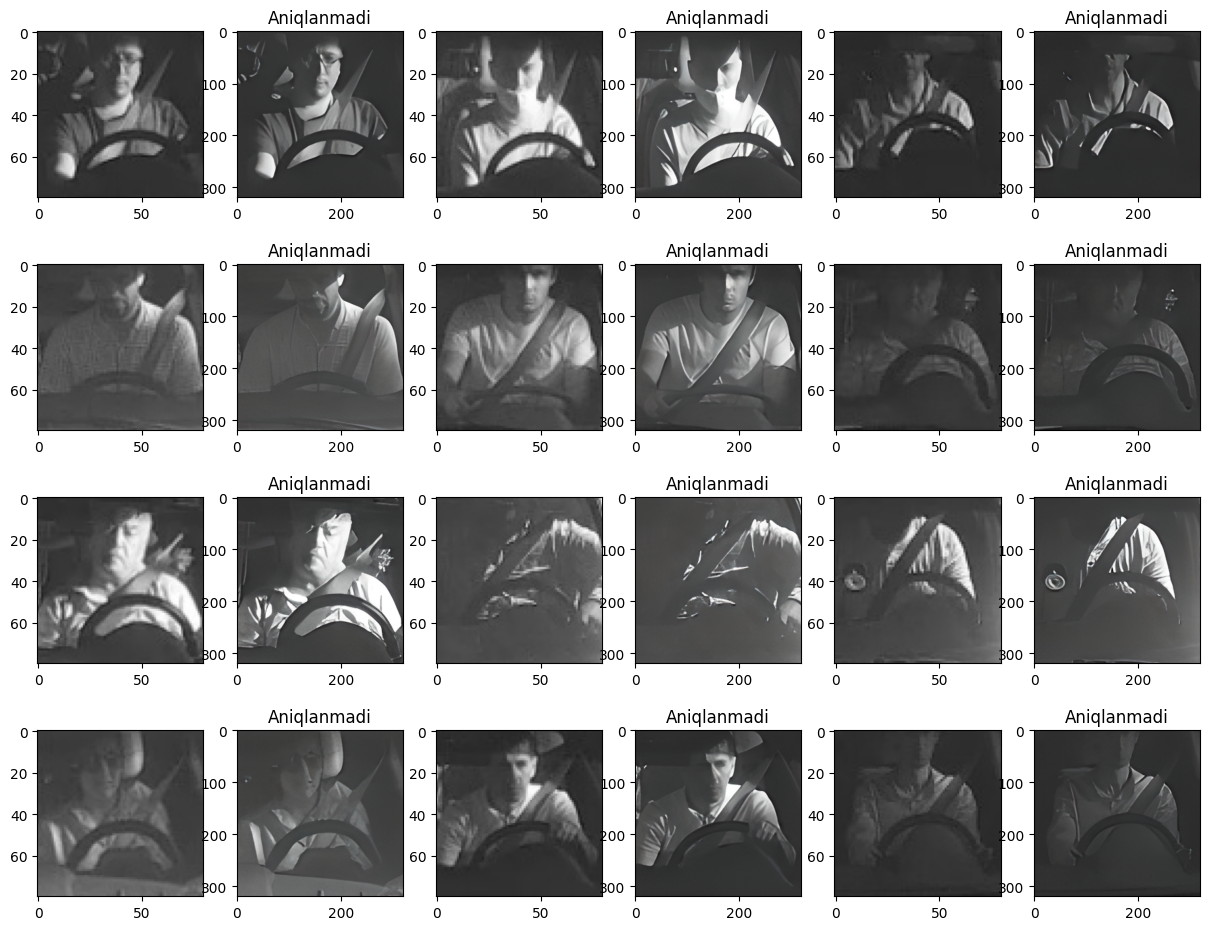

In [1]:
from realesrgan import RealESRGANer, RRDBNet
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

def resolution(input_img):
    """
    Inference demo for Real-ESRGAN.
    """
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
    netscale = 4

    # determine model paths
    model_path = 'models/RealESRGAN_x4plus.pth'

    # use dni to control the denoise strength
    dni_weight = None

    # restorer
    upsampler = RealESRGANer(
        scale=netscale,
        model_path=model_path,
        dni_weight=dni_weight,
        model=model,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=False,
        device='cuda',
        gpu_id=0)

    try:
        output, _ = upsampler.enhance(input_img, outscale=4)
        return output
    except RuntimeError as error:
        return f'Error {error}\nIf you encounter CUDA out of memory, try to set tile with a smaller number.'

def predict_seatbelt_tensorflow(image, model):
    types = ['Taqilgan', 'Taqilmagan', 'Aniqlanmadi']
    if np.mean(image.shape[:2]) > 300:
        image = cv2.resize(image, (320, 320)) / 255.0
        return types[np.argmax(model(np.expand_dims(image, axis = 0)))]
    else:
        image = resolution(image)
        image = cv2.resize(image, (320, 320)) / 255.0
        return types[np.argmax(model(np.expand_dims(image, axis = 0)))]

model = load_model('models/seatbelt.model')

rasmlar = glob('kamarli/*')
plt.figure(figsize=(15, 60))
j = 1
false = 0
number_sample = 12
for i in range(number_sample):
    img = cv2.imread(rasmlar[len(rasmlar)-i-1])
    plt.subplot(20, 6, j)
    j += 1
    plt.imshow(img)
    plt.subplot(20, 6, j)
    j += 1
    plt.imshow(resolution(img))
    result = predict_seatbelt_tensorflow(img, model)
    if result != "Taqilgan":
        false += 1
    plt.title(result)
print(f"{100*((number_sample-false)/number_sample)} % accuracy")

## Seatbelt classification with Pytorch

In [2]:
from torch import nn, optim, save, cuda, from_numpy
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
import cv2
import torch.nn.functional as F
import torchvision.transforms as transforms
import math

In [3]:
b_size = 16
num_classes = 3

train_dataset = datasets.ImageFolder('Data/train',transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder('Data/test',transform=transforms.ToTensor())

train_data = data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_data = data.DataLoader(test_dataset, batch_size=b_size, shuffle=False)

In [4]:
class SeatBelt(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.norm1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        self.norm2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.norm3 = nn.BatchNorm2d(64)
        self.drop3 = nn.Dropout(0.2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding='same')
        self.norm4 = nn.BatchNorm2d(128)
        self.drop4 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding='same')
        self.norm5 = nn.BatchNorm2d(256)
        self.drop5 = nn.Dropout(0.2)

        self.conv6 = nn.Conv2d(256, 512, 3, padding='same')
        self.norm6 = nn.BatchNorm2d(512)
        self.drop6 = nn.Dropout(0.2)
        
        self.pool = nn.MaxPool2d(2)
        self.l1 = nn.Linear(512*5*5, 1024)
        self.l2 = nn.Linear(1024, 256)
        self.l3 = nn.Linear(256, num_classes)

        self.data_aug = transforms.Compose([
                                            transforms.RandomVerticalFlip(p=1),
                                            transforms.RandomHorizontalFlip(p=1),
                                            transforms.RandomRotation(0.2)
                                        ])
        
    def forward(self, x):
        x = self.data_aug(x)

        x = F.relu(self.conv1(x))
        x = self.pool(self.norm1(x))
        x = self.drop1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(self.norm2(x))
        x = self.drop2(x)

        x = F.relu(self.conv3(x))
        x = self.pool(self.norm3(x))
        x = self.drop3(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(self.norm4(x))
        x = self.drop4(x)

        x = F.relu(self.conv5(x))
        x = self.pool(self.norm5(x))
        x = self.drop5(x)

        x = F.relu(self.conv6(x))
        x = self.pool(self.norm6(x))
        x = self.drop6(x)

        x = x.view(-1, 512*5*5)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
    
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

model = SeatBelt()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimize = optim.Adam(model.parameters(), lr=0.001)
steps = math.ceil(len(train_data.dataset) / b_size)

def train(epoch):
    model.train()
    for b_i, datas in enumerate(train_data):
        data, label = datas[0], datas[1]
        data /= 255.0
        data, label = data.to(device), label.to(device)
        optimize.zero_grad()
        predict = model(data)
        loss = criterion(predict, label)
        loss.backward()
        optimize.step()
        if b_i == steps - 1:
            print(f"Epoch - {epoch} | {b_i}  {b_i*len(data)}/{len(train_data.dataset)} | Loss {loss.item()}")
        else:
            print(f"Epoch - {epoch} | {b_i}  {b_i*len(data)}/{len(train_data.dataset)} | Loss {loss.item()}", end='\r')

def test():
    model.eval()
    true = 0
    for data, label in test_data:
        data, label = data.to(device), label.to(device)
        predict = model(data)
        result = predict.data.argmax(1, keepdim=True)[1]
        true += result.eq(label.data).cpu().sum()
    print(f"Accuracy - {true/len(test_data.dataset)}")
    
for epoch in range(100):
    train(epoch)
    test()
save(model.state_dict(),'models/seatbelt.pt')

cuda
Epoch - 0 | 124  1984/2000 | Loss 0.9696299433708191
Accuracy - 0.2298850566148758
Epoch - 1 | 124  1984/2000 | Loss 0.34471696615219116
Accuracy - 0.5517241358757019
Epoch - 2 | 124  1984/2000 | Loss 0.7163916826248169
Accuracy - 0.588505744934082
Epoch - 3 | 124  1984/2000 | Loss 0.6479094028472966
Accuracy - 0.3011494278907776
Epoch - 4 | 124  1984/2000 | Loss 0.49469488859176636
Accuracy - 0.5517241358757019
Epoch - 5 | 124  1984/2000 | Loss 0.93081665039062524
Accuracy - 0.4850574731826782
Epoch - 6 | 124  1984/2000 | Loss 0.35786297917366035
Accuracy - 0.5517241358757019
Epoch - 7 | 124  1984/2000 | Loss 0.15596494078636175
Accuracy - 0.5218390822410583
Epoch - 8 | 124  1984/2000 | Loss 0.09221874177455902
Accuracy - 0.45057472586631775
Epoch - 9 | 124  1984/2000 | Loss 0.19084112346172333
Accuracy - 0.5218390822410583
Epoch - 10 | 124  1984/2000 | Loss 0.532598316669464125
Accuracy - 0.5149425268173218
Epoch - 11 | 124  1984/2000 | Loss 1.258728742599487373
Accuracy - 0.521

In [ ]:
from torch import load, FloatTensor
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os

def predict_seatbelt_torch(image, model):
    types = ['Taqilgan', 'Taqilmagan', 'Aniqlanmadi']
    # if the image size is close to 320, we use resolution to the image. Otherwise don't use
    if np.mean(image.shape[:2]) > 300:
        image = cv2.resize(image, (320, 320)) / 255.0
        image = image.transpose((2, 0, 1))
        image = FloatTensor(np.expand_dims(image, axis = 0))
        return types[np.argmax(model(image).detach().numpy())]
    else:
        image = resolution(image)
        image = cv2.resize(image, (320, 320)) / 255.0
        image = image.transpose((2, 0, 1))
        image = FloatTensor(np.expand_dims(image, axis = 0))
        return types[np.argmax(model(image).detach().numpy())]

model = SeatBelt()
model.load_state_dict(load('models/seatbelt.pt'))
model.to('cuda')
model.eval()

rasmlar = glob('kamarli/*')
plt.figure(figsize=(15, 60))
j = 1
notugri = 0
number_sample = 12
for i in range(number_sample):
    img = cv2.imread(rasmlar[len(rasmlar)-i-1])
    plt.subplot(20, 6, j)
    j+=1
    plt.imshow(img)
    plt.subplot(20, 6, j)
    j+=1
    plt.imshow(resolution(img))
    result = predict_seatbelt_torch(img, model)
    if result != "Taqilgan":
        notugri += 1
    plt.title(result)
print(f"{100*((number_sample - notugri)/number_sample)} % accuracy")